[*********************100%***********************]  1 of 1 completed
C:\Users\nilee\AppData\Local\Temp\ipykernel_15364\2829056449.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usd_cad.rename(columns={'Adj Close': 'usd_cad'}, inplace=True)


                  GDP       NFP      CPI  Retail Sales  usd_cad
2015-01-01  18063.529  140562.0  234.747      385312.0  1.16146
2015-04-01  18279.784  141202.0  236.222      391246.0  1.26880
2015-05-01        NaN  141539.0  237.001      394260.0  1.20780
2015-06-01        NaN  141695.0  237.657      394652.0  1.24561
2015-07-01  18401.626  141989.0  238.034      397994.0  1.24770


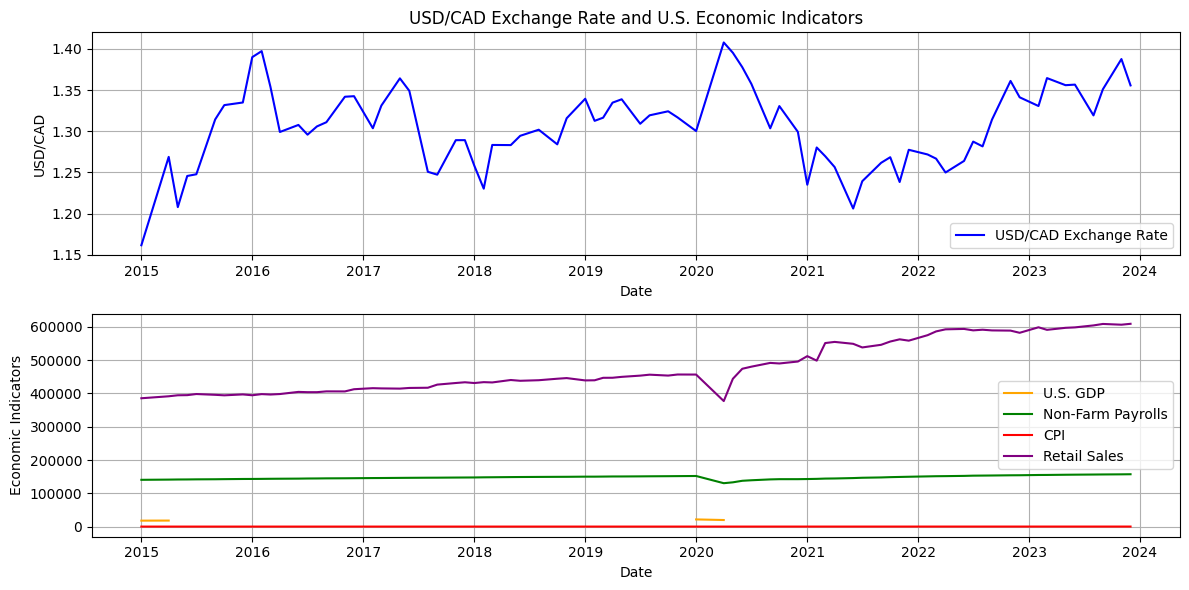

In [3]:
from fredapi import Fred
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Set up FRED API (replace 'YOUR_API_KEY' with your actual FRED API key)
fred = Fred(api_key='495cd17849c9527846a6318bd3ecc94c')

# Step 1: Fetch U.S. Economic Data from FRED
def get_us_economic_data_fred():
    # Fetch U.S. GDP data from FRED
    gdp_data = fred.get_series("GDP", observation_start="2015-01-01")
    
    # Fetch U.S. Non-Farm Payroll (NFP) data
    nfp_data = fred.get_series("PAYEMS", observation_start="2015-01-01")
    
    # Fetch U.S. CPI data
    cpi_data = fred.get_series("CPIAUCSL", observation_start="2015-01-01")
    
    # Fetch U.S. Retail Sales data
    retail_sales_data = fred.get_series("RSXFS", observation_start="2015-01-01")
    
    # Merge all data into one dataframe
    economic_data = pd.concat([gdp_data, nfp_data, cpi_data, retail_sales_data], axis=1)
    economic_data.columns = ['GDP', 'NFP', 'CPI', 'Retail Sales']
    return economic_data

# Step 2: Fetch USD/CAD exchange rate data using yfinance
def get_usd_cad_data_yf():
    # Fetching the USD/CAD exchange rate data using ticker symbol "CAD=X"
    usd_cad = yf.download("CAD=X", start="2015-01-01", end="2024-01-01")
    # Adjusting the dataframe to keep only the adjusted close prices
    usd_cad = usd_cad[['Adj Close']]
    usd_cad.rename(columns={'Adj Close': 'usd_cad'}, inplace=True)
    return usd_cad

# Fetch the data
economic_data = get_us_economic_data_fred()
usd_cad_data = get_usd_cad_data_yf()

# Merge dataframes on date
data = economic_data.merge(usd_cad_data, left_index=True, right_index=True, how='inner')

# Display the first few rows
print(data.head())

# Plot the data
plt.figure(figsize=(12, 6))

# Plot USD/CAD exchange rate
plt.subplot(2, 1, 1)
plt.plot(data.index, data['usd_cad'], label='USD/CAD Exchange Rate', color='blue')
plt.title('USD/CAD Exchange Rate and U.S. Economic Indicators')
plt.xlabel('Date')
plt.ylabel('USD/CAD')
plt.legend()
plt.grid()

# Plot GDP, NFP, CPI, and Retail Sales
plt.subplot(2, 1, 2)
plt.plot(data.index, data['GDP'], label='U.S. GDP', color='orange')
plt.plot(data.index, data['NFP'], label='Non-Farm Payrolls', color='green')
plt.plot(data.index, data['CPI'], label='CPI', color='red')
plt.plot(data.index, data['Retail Sales'], label='Retail Sales', color='purple')
plt.xlabel('Date')
plt.ylabel('Economic Indicators')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [9]:
# Step 3: Generate Trading Signals based on economic data

# Moving averages for each economic indicator
data['GDP_MA'] = data['GDP'].rolling(window=3).mean()
data['NFP_MA'] = data['NFP'].rolling(window=3).mean()
data['CPI_MA'] = data['CPI'].rolling(window=3).mean()

# GDP Signal: Go long if GDP is higher than its 3-month moving average
data['GDP_Signal'] = 0
data['GDP_Signal'] = data['GDP'] > data['GDP_MA']

# NFP Signal: Go long if NFP is higher than its 3-month moving average
data['NFP_Signal'] = 0
data['NFP_Signal'] = data['NFP'] > data['NFP_MA']

# CPI Signal: Go short if CPI is rising (CPI > its moving average)
data['CPI_Signal'] = 0
data['CPI_Signal'] = data['CPI'] < data['CPI_MA']

In [11]:
# Step 4: Combine the signals into a final trading signal
data['Final_Signal'] = data['GDP_Signal'] + data['NFP_Signal'] ^ data['CPI_Signal']

# Trading Logic: Long if final signal > 0, Short if final signal < 0
data['Position'] = 0
data['Position'][data['Final_Signal'] > 0] = 1  # Go long
data['Position'][data['Final_Signal'] < 0] = -1  # Go short

C:\Users\nilee\AppData\Local\Temp\ipykernel_15364\2789837783.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Position'][data['Final_Signal'] > 0] = 1  # Go long
C:\Users\nilee\AppData\Local\Temp\ipykernel_15364\2789837783.py:6: Set

In [12]:
data

,GDP,NFP,CPI,Retail Sales,usd_cad,GDP_MA,NFP_MA,CPI_MA,GDP_Signal,NFP_Signal,CPI_Signal,Position,Final_Signal
2015-01-01,18063.529,140562.0,234.747,385312.0,1.16146,NaN,NaN,NaN,False,False,False,0,False
2015-04-01,18279.784,141202.0,236.222,391246.0,1.26880,NaN,NaN,NaN,False,False,False,0,False
2015-05-01,NaN,141539.0,237.001,394260.0,1.20780,NaN,141101.000000,235.990000,False,True,False,1,True
2015-06-01,NaN,141695.0,237.657,394652.0,1.24561,NaN,141478.666667,236.960000,False,True,False,1,True
2015-07-01,18401.626,141989.0,238.034,397994.0,1.24770,NaN,141741.000000,237.564000,False,True,False,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,NaN,156027.0,304.003,598006.0,1.35660,NaN,155673.333333,303.037333,False,True,False,1,True
2023-08-01,NaN,156421.0,306.187,603889.0,1.31920,NaN,156078.333333,304.518333,False,True,False,1,True
2023-09-01,NaN,156667.0,307.288,608307.0,1.35097,NaN,156371.666667,305.826000,False,True,False,1,True
2023-11-01,NaN,157014.0,308.024,606035.0,1.38766,NaN,156700.666667,307.166333,False,True,False,1,True


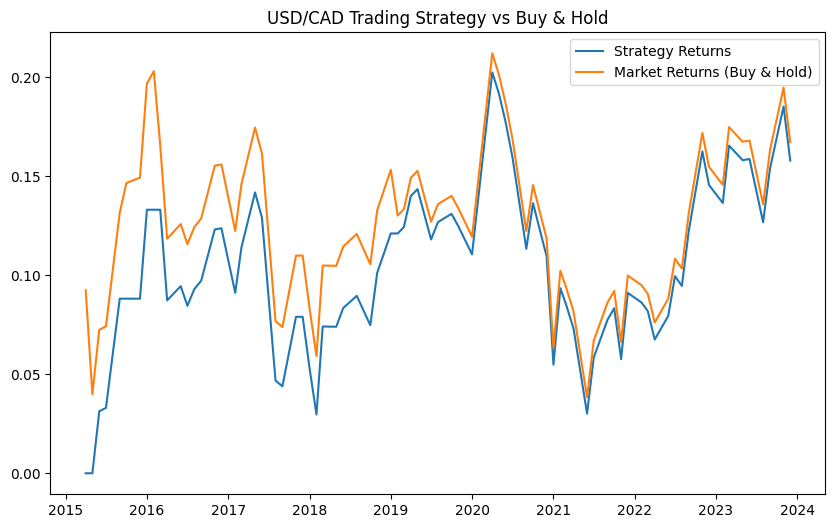

In [15]:
# Step 5: Calculate strategy returns
data['USD/CAD Returns'] = data['usd_cad'].pct_change()
data['Strategy_Returns'] = data['Position'].shift(1) * data['USD/CAD Returns']

# Step 6: Calculate cumulative returns
data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Returns']).cumprod() - 1
data['Cumulative_Market_Returns'] = (1 + data['USD/CAD Returns']).cumprod() - 1

# Step 7: Plot the cumulative returns

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.plot(data.index, data['Cumulative_Market_Returns'], label='Market Returns (Buy & Hold)')
plt.title("USD/CAD Trading Strategy vs Buy & Hold")
plt.legend()
plt.show()

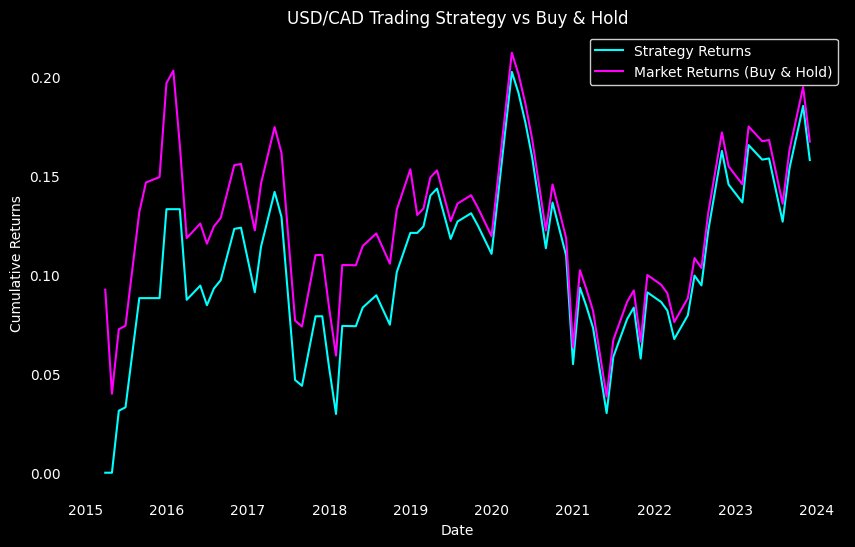

In [17]:
import matplotlib.pyplot as plt

# Step 7: Plot the cumulative returns with a black background

plt.figure(figsize=(10, 6))
plt.gca().set_facecolor('black')  # Set plot background to black
plt.gcf().patch.set_facecolor('black')  # Set figure background to black

# Plotting cumulative returns
plt.plot(data.index, data['Cumulative_Strategy_Returns'], label='Strategy Returns', color='cyan')
plt.plot(data.index, data['Cumulative_Market_Returns'], label='Market Returns (Buy & Hold)', color='magenta')

# Customizing labels, title, and legend
plt.title("USD/CAD Trading Strategy vs Buy & Hold", color='white')
plt.xlabel("Date", color='white')
plt.ylabel("Cumulative Returns", color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.legend(facecolor='black', edgecolor='white', labelcolor='white')

# Show the plot
plt.show()